# Some more statistical tests

Below we have some version of T-test and BT from the paper "The paper "Better than Average: Paired Evaluation of NLP Systems""


In [2]:
#!pip install pairformance

#!pip install pingouin

In [3]:
from IPython.lib.deepreload import reload
%load_ext autoreload
%autoreload 2

from examples.few_shot.scripts.collect_results import load_results, get_predictions_gold_probability_for_results_file, print_json_structure

# prediction_gold_scores_hard: List[List[float]] = get_predictions_gold_probability_for_results_file(results_file, soft_scores=False, ensemble=True)

In [4]:
import os
import pprint
import pandas as pd
from pandas import DataFrame
import sys

from pairformance.core import DEFAULT_CONFIG
from pairformance import plotting_utils
import pairformance

pp = pprint.PrettyPrinter(indent=4)

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import logging
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.colors import LinearSegmentedColormap
cmap_green_yellow_red = LinearSegmentedColormap.from_list(
    name='test', 
    colors=['green','yellow','red']
)
import matplotlib
matplotlib._log.disabled = True
logging.basicConfig(level='CRITICAL')
# Turn off sina logging
for name in [
             "matplotlib", "matplotlib.font", "matplotlib.pyplot"]:
    logger = logging.getLogger(name)
    logger.setLevel(logging.CRITICAL)
    logger.disabled = True
    
from scipy.stats import bootstrap

import numpy as np
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

# Filter the rows that we want to evaluate
def filter_by(df, constraints, skip_none_filter_vals=True):
    """Filter MultiIndex by sublevels.
       source: https://stackoverflow.com/questions/25224545/filtering-multiple-items-in-a-multi-index-python-panda-dataframe
    """
    constraints = {k: v if isinstance(v, list) else [v] for k,v in constraints.items() if v is not None}
    if len(constraints) == 0:
        return df
    
    indexer = [constraints[name] if name in constraints else slice(None)
               for name in df.index.names]
    return df.loc[tuple(indexer)] if len(df.shape) == 1 else df.loc[tuple(indexer),]

pd.Series.filter_by = filter_by
pd.DataFrame.filter_by = filter_by

DEBUG - matplotlib data path: /private/home/shuohui/.conda/envs/fairseq-20210102/lib/python3.8/site-packages/matplotlib/mpl-data
DEBUG - CONFIGDIR=/private/home/shuohui/.config/matplotlib
DEBUG - matplotlib version 3.4.3
DEBUG - interactive is False
DEBUG - platform is linux
DEBUG - loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_warnings', '_frozen_importlib_external', '_io', 'marshal', 'posix', '_thread', '_weakref', 'time', 'zipimport', '_codecs', 'codecs', 'encodings.aliases', 'encodings', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', '_abc', 'abc', 'io', '_stat', 'stat', '_collections_abc', 'genericpath', 'posixpath', 'os.path', 'os', '_sitebuiltins', '_locale', '_bootlocale', 'types', 'importlib._bootstrap', 'importlib._bootstrap_external', 'warnings', 'importlib', 'importlib.machinery', 'importlib.abc', '_operator', 'operator', 'keyword', '_heapq', 'heapq', 'itertools', 'reprlib', '_collections', 'collections', '_functools', 'functools', 'cont

DEBUG - CACHEDIR=/private/home/shuohui/.cache/matplotlib
DEBUG - Using fontManager instance from /private/home/shuohui/.cache/matplotlib/fontlist-v330.json
DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.


# Loading our data 

In [5]:
# Load our results

results_raw_jsonl_list = ["/checkpoint/victorialin/few_shot/dense_7.5B_lang30_new_cc100_xl_unigram_mutli_tasks_v1/results.tsv.raw.jsonl",
                          "/checkpoint/victorialin/few_shot/dense_7.5B_lang30_new_cc100_xl_unigram_en_tasks/results.tsv.raw.jsonl"]

#results_raw_jsonl_list = ["/large_experiments/xlmg/results/multilingual/dense_7_5B_30lang_cpts/results.tsv.raw.jsonl"]
all_results = []
for results_raw_file in results_raw_jsonl_list:
    results, expanded_results, current_tasks_to_groups  = load_results(results_raw_file)
    all_results.extend(results)

results = all_results
print(f"{len(results)} loaded")

2516 loaded


# Process results
Filter some columns for faster processing

In [6]:
# Group by the unique keys

df = pd.DataFrame.from_records(results)

# these are the fields that we want to group by
index_cols = ["task", 
              "language",
              "eval_examples_cnt",
              "eval_set", 
              "train_set", 
              "train_lang",
              "nb_few_shot_samples", 
              "calibration",
              "template",
              "model_name", # we need the results file to load the predictions
             ]
value_cols_all = ["_metric_val",
                  "_metric_val_std",
              "results_file"]  # this is only the preferred value
value_cols = [x for x in value_cols_all if x in df.columns]
cols = []

df_selected = df[index_cols + value_cols + cols]

# debug - group by
# pt = pd.pivot_table(df_selected, values=value_cols, index=index_cols,
#                    columns=cols, aggfunc=[np.mean])
# pt = pt.swaplevel(1, 2, axis=1).sort_index(axis=1)
# pt

df_selected = df_selected.set_index(index_cols)  # this is for easy filtering
df_selected


_metric_val  \
task      language eval_examples_cnt eval_set train_set train_lang nb_few_shot_samples calibration template model_name                                                        
xwinograd en       2325              test     test      en         0                   False       winograd dense_7.5B_lang30_new_cc100_xl_unigram__step000...    53.419355   
          fr       83                test     test      fr         0                   False       winograd dense_7.5B_lang30_new_cc100_xl_unigram__step000...    49.397590   
          jp       959               test     test      jp         0                   False       winograd dense_7.5B_lang30_new_cc100_xl_unigram__step000...    49.635036   
          pt       263               test     test      pt         0                   False       winograd dense_7.5B_lang30_new_cc100_xl_unigram__step000...    52.851711   
          ru       315               test     test      ru         0                   False       winograd dense_7.5B_lang30_new_cc100_xl_unigram__step000...    54.285714   
...                                                                                                                                                                     ...   
copa      en       100               val      train     en         1                   False       copa     dense_7.5B_lang30_new_cc100_xl_unigram__step002...    69.200000   
                                                                   4                   False       copa     dense_7.5B_lang30_new_cc100_xl_unigram__step002...    71.200000   
                                                                   128                 False       copa     dense_7.5B_lang30_new_cc100_xl_unigram__step002...    70.400000   
                                                                   2048                False       copa     dense_7.5B_lang30_new_cc100_xl_unigram__step002...    70.200000   
                                                                   32                  False       copa     dense_7.5B_lang30_new_cc100_xl_unigram__step002...    71.400000   

                                                                                                                                                                _metric_val_std  \
task      language eval_examples_cnt eval_set train_set train_lang nb_few_shot_samples calibration template model_name                                                            
xwinograd en       2325              test     test      en         0                   False       winograd dense_7.5B_lang30_new_cc100_xl_unigram__step000...         0.000000   
          fr       83                test     test      fr         0                   False       winograd dense_7.5B_lang30_new_cc100_xl_unigram__step000...         0.000000   
          jp       959               test     test      jp         0                   False       winograd dense_7.5B_lang30_new_cc100_xl_unigram__step000...         0.000000   
          pt       263               test     test      pt         0                   False       winograd dense_7.5B_lang30_new_cc100_xl_unigram__step000...         0.000000   
          ru       315               test     test      ru         0                   False       winograd dense_7.5B_lang30_new_cc100_xl_unigram__step000...         0.000000   
...                                                                                                                                                                         ...   
copa      en       100               val      train     en         1                   False       copa     dense_7.5B_lang30_new_cc100_xl_unigram__step002...         1.166190   
                                                                   4                   False       copa     dense_7.5B_lang30_new_cc100_xl_unigram__step002...         1.939072   
                                                                   128                 False  

# Filter data 
Filter here to improve the performance.
We will do pairwise comparisons below!  

In [7]:

filter_json = {
    'task': ["storycloze"], 
    'language': ["en"], 
    'eval_examples_cnt': None, 
    'eval_set': ["val2016"], 
    'train_set': None,
    'train_lang': None, 
    'nb_few_shot_samples': None, 
    'calibration': None, 
    'template': None,
    'model_name': ["dense_7.5B_lang30_new_cc100_xl_unigram__step00238000"]
}



df_filtered = df_selected.filter_by(
    filter_json
)
# df_filtered.to_csv("results_debug.tsv")
df_filtered

_metric_val  \
task       language eval_examples_cnt eval_set train_set train_lang nb_few_shot_samples calibration template   model_name                                                        
storycloze en       1871              val2016  val2016   en         0                   False       storycloze dense_7.5B_lang30_new_cc100_xl_unigram__step002...    75.521112   
                                                                    16                  False       storycloze dense_7.5B_lang30_new_cc100_xl_unigram__step002...    77.220738   
                                                                    1                   False       storycloze dense_7.5B_lang30_new_cc100_xl_unigram__step002...    75.050775   
                                                                    4                   False       storycloze dense_7.5B_lang30_new_cc100_xl_unigram__step002...    76.771780   
                                                                    32                  False       storycloze dense_7.5B_lang30_new_cc100_xl_unigram__step002...    77.295564   
                                                                    128                 False       storycloze dense_7.5B_lang30_new_cc100_xl_unigram__step002...    77.359701   
                                                                    1                   False       storycloze dense_7.5B_lang30_new_cc100_xl_unigram__step002...    75.050775   

                                                                                                                                                                   _metric_val_std  \
task       language eval_examples_cnt eval_set train_set train_lang nb_few_shot_samples calibration template   model_name                                                            
storycloze en       1871              val2016  val2016   en         0                   False       storycloze dense_7.5B_lang30_new_cc100_xl_unigram__step002...         0.000000   
                                                                    16                  False       storycloze dense_7.5B_lang30_new_cc100_xl_unigram__step002...         0.972331   
                                                                    1                   False       storycloze dense_7.5B_lang30_new_cc100_xl_unigram__step002...         1.060038   
                                                                    4                   False       storycloze dense_7.5B_lang30_new_cc100_xl_unigram__step002...         0.684126   
                                                                    32                  False       storycloze dense_7.5B_lang30_new_cc100_xl_unigram__step002...         0.654943   
                                                                    128                 False       storycloze dense_7.5B_lang30_new_cc100_xl_unigram__step002...         0.339043   
                                                                    1                   False       storycloze dense_7.5B_lang30_new_cc100_xl_unigram__step002...         1.060038   

                                                                                                                                                                                                        results_file  
task       language eval_examples_cnt eval_set train_set train_lang nb_few_shot_samples calibration template   model_name                                                                                             
storycloze en       1871              val2016  val2016   en         0                   False       storycloze dense_7.5B_lang30_new_cc100_xl_unigram__step002...  /checkpoint/victorialin/few_shot/dense_7.5B_la...  
                                                                    16                  False       storycloze dense_7.5B_lang30_new_cc100_xl_unigram__step002...  /checkpoint/victorialin/few_shot/dense_7.5B_la...  
                                                             

### Load data
Below we load the predictions for each evaluation. 
Instead of using aggregated metrics like accuracy, we will use 
the probability score that the system assigned to the correct answer for each example and these 
will be used for pairwise comparison between the systems.

In [8]:
predictions_by_index = {}
predictions_by_index_soft = {}

for index, row in df_filtered.iterrows():
    if index in predictions_by_index:
        # only unique values
        continue
    results_file = row["results_file"]
    if not os.path.exists(results_file):
        print("Does not exist:" + row["results_file"])
        continue
    print(index)
    print(row["results_file"])
    # We use the descrete predictions for Ttest
    prediction_gold_scores_correct_soft = get_predictions_gold_probability_for_results_file(results_file, 
                                                                               soft_scores=False, # False == IsCorrect
                                                                               ensemble="mean") # this will ensemble runs with multiple shots.
    predictions_by_index[index] = prediction_gold_scores_correct_soft[0] # this is ensemble so it always have 1 value
    
    # we need continuos scores for BT
    prediction_gold_scores_correct = get_predictions_gold_probability_for_results_file(results_file, 
                                                                               soft_scores=True, # False == IsCorrect
                                                                               ensemble="mean") # this will ensemble runs with multiple shots.
    predictions_by_index_soft[index] = prediction_gold_scores_correct[0]



('storycloze', 'en', 1871, 'val2016', 'val2016', 'en', 0, False, 'storycloze', 'dense_7.5B_lang30_new_cc100_xl_unigram__step00238000')
/checkpoint/victorialin/few_shot/dense_7.5B_lang30_new_cc100_xl_unigram_mutli_tasks_v1/storycloze_dense_7.5B_lang30_new_cc100_xl_unigram__step00238000_fs.0_t5_smpl.All_current/task.storycloze_tmp.storycloze_train.val2016.en_val.None.en_eval.val2016.en_calib.None_fs0_results.json
('storycloze', 'en', 1871, 'val2016', 'val2016', 'en', 16, False, 'storycloze', 'dense_7.5B_lang30_new_cc100_xl_unigram__step00238000')
/checkpoint/victorialin/few_shot/dense_7.5B_lang30_new_cc100_xl_unigram_mutli_tasks_v1/storycloze_dense_7.5B_lang30_new_cc100_xl_unigram__step00238000_fs.16_64_t5_smpl.All_current/task.storycloze_tmp.storycloze_train.val2016.en_val.None.en_eval.val2016.en_calib.None_fs16_results.json
('storycloze', 'en', 1871, 'val2016', 'val2016', 'en', 1, False, 'storycloze', 'dense_7.5B_lang30_new_cc100_xl_unigram__step00238000')
/checkpoint/victorialin/few_s

In [9]:
names_frequency = {}
index_names = list(df_filtered.index.names)
names_frequency = {n:[] for n in index_names}

predictions_with_index = []
for key, preds in list(predictions_by_index.items()):
    index_with_pred_item = {"index":key, "predictions_descrete": preds, "predictons_score":predictions_by_index_soft[key] }
    index_name_key_dict = {index_name: val for index_name, val in zip(index_names, list(key))}
    index_with_pred_item["index_named_values"] = index_name_key_dict
    
    predictions_with_index.append(index_with_pred_item)
    
    # add values to names frequencies
    for index_name, val in index_name_key_dict.items():
        names_frequency[index_name].append(val)

# get the fields that have the same values for all entries
names_frequency_cnts = {k: len(set(v)) for k,v in names_frequency.items()}
group_index_names = [k for k,v in names_frequency_cnts.items() if v == 1]

def get_index_common(index_named_values, group_index_names):
    """Forms a readable name"""
    return [v for k,v in index_named_values.items() if k in group_index_names]

index_key_to_short = {"nb_few_shot_samples": "nshot"}
def get_index_unique(index_named_values, group_index_names):
    """Forms a unique readable name"""
    
    return ",".join([f"{index_key_to_short.get(k, k)}: {v}" for k,v in index_named_values.items() if k not in group_index_names])

np.random.seed(seed=1)
rng = np.random.default_rng()
for item in predictions_with_index:
    item["index_common"] = get_index_common(item["index_named_values"], group_index_names)
    item["index_unique"] = get_index_unique(item["index_named_values"], group_index_names)
    item["mean_score"] = np.mean(item["predictions_descrete"])
#     item["confidence"] =  bootstrap((item, ), np.std, confidence_level=0.95,
#                 random_state=rng)

#for k, preds in predictions_by_index.items():
#predictions_with_index[0]

In [10]:
print("The structure of the predictions:")
print_json_structure(predictions_with_index)

The structure of the predictions:
  item[0]: dict
    index: tuple
    predictions_descrete: list (1871)
        item[0]: float64 = '0.0'
    predictons_score: list (1871)
        item[0]: float64 = '0.19657658562451466'
    index_named_values: dict
      task: str = 'storycloze'
      language: str = 'en'
      eval_examples_cnt: int = '1871'
      eval_set: str = 'val2016'
      train_set: str = 'val2016'
      train_lang: str = 'en'
      nb_few_shot_samples: int = '0'
      calibration: bool = 'False'
      template: str = 'storycloze'
      model_name: str = 'dense_7.5B_lang30_new_cc100_xl_unigram__step00238000'
    index_common: list (9)
        item[0]: str = 'storycloze'
    index_unique: str = 'nshot: 0'
    mean_score: float64 = '0.755211117049706'


# Using scipy.stats.ttest_ind to compare predictions_descrete
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html

In [11]:
# T-test
from scipy import stats

predictions_with_index = sorted(predictions_with_index, key=lambda x: x["mean_score"], reverse=True)

systems_count = len(predictions_with_index)
significance_matrix = -np.ones((systems_count, systems_count))

# print names with scores
model_scores = [(x["index_unique"], x["mean_score"]) for x in predictions_with_index]
model_labels_y_axis = [f"{x[0]} {(np.round(np.mean(x[1]),4), np.round(np.std(x[1]),4))}" for x in model_scores]
model_labels_x_axis = [f" {(np.round(np.mean(x[1]),4), np.round(np.std(x[1]),4))}" for x in model_scores]
        
for i0, systemA in enumerate(predictions_with_index):
    systemA_scores = systemA["predictions_descrete"]
    systemA_name = systemA["index_unique"]

    for i1, systemB in enumerate(predictions_with_index):
        systemB_scores = systemB["predictions_descrete"]
        systemB_name = systemB["index_unique"]
        if systemA_name == systemB_name:
            continue
        
        statistic, pval = stats.ttest_ind(systemA_scores, systemB_scores)
#         print(f"{systemA_name}: {np.mean(systemA_scores)}")
#         print(f"{systemB_name}: {np.mean(systemB_scores)}")
#         print(f"statistic={statistic}, p-val={pval}")
#         print()
        significance_matrix[i0, i1] = pval
        significance_matrix[i1, i0] = pval

sig_matrix_mask = significance_matrix < 0
significance_matrix = np.around(significance_matrix, 3)

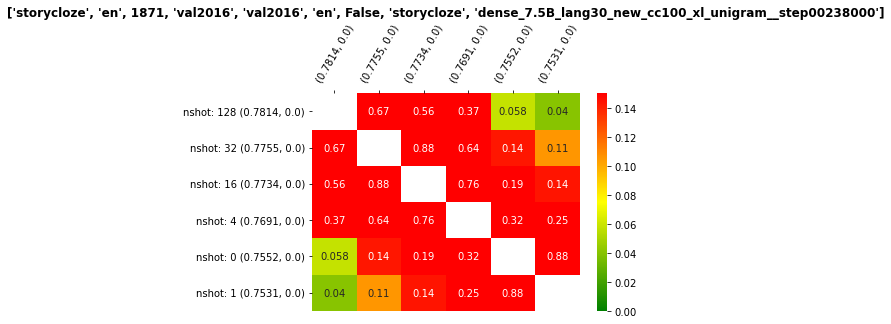

In [12]:
max_p_val=0.05
sig_matrix_mask = significance_matrix < 0
significance_matrix = np.around(significance_matrix, 3)
ax = sns.heatmap(significance_matrix, 
            mask=sig_matrix_mask, 
            xticklabels=model_labels_x_axis,
            yticklabels=model_labels_y_axis,
            vmin=0.00,
            vmax=3*max_p_val,
            annot=True,
            cmap=cmap_green_yellow_red)
plt.yticks(rotation=0)
ax.tick_params(axis='x', rotation=60)
ax.xaxis.tick_top() # x axis on top
ax.xaxis.set_label_position('top')
ax.set_title(predictions_with_index[0]["index_common"], weight='bold')

plt.show()

# Using pingouin.power_ttest to compare predictions_descrete
https://pingouin-stats.org/generated/pingouin.power_ttest.html

In [16]:
from pingouin import power_ttest

In [39]:
predictions_with_index = sorted(predictions_with_index, key=lambda x: x["mean_score"], reverse=True)

systems_count = len(predictions_with_index)
significance_matrix = -np.ones((systems_count, systems_count))

# print names with scores
model_scores = [(x["index_unique"], x["mean_score"]) for x in predictions_with_index]
model_labels_y_axis = [f"{x[0]} {(np.round(np.mean(x[1]),4), np.round(np.std(x[1]),4))}" for x in model_scores]
model_labels_x_axis = [f" {(np.round(np.mean(x[1]),4), np.round(np.std(x[1]),4))}" for x in model_scores]
        
for i0, systemA in enumerate(predictions_with_index):
    systemA_scores = systemA["predictions_descrete"]
    systemA_name = systemA["index_unique"]

    for i1, systemB in enumerate(predictions_with_index):
        systemB_scores = systemB["predictions_descrete"]
        systemB_name = systemB["index_unique"]
        if systemA_name == systemB_name:
            continue
        
#         statistic, pval = stats.ttest_ind(systemA_scores, systemB_scores)
        effect_size = np.mean(np.array(systemA_scores) - np.array(systemB_scores)) / \
                np.std(np.array(systemA_scores) - np.array(systemB_scores))
#         pval = ttpower.solve_power(effect_size=effect_size, nobs=len(systemA_scores), power=0.9, alternative='two-sided')
        pval = power_ttest(d=effect_size, n=len(systemA_scores)-1, power=0.9, alpha=None, alternative='two-sided')
        significance_matrix[i0, i1] = pval
        significance_matrix[i1, i0] = pval

sig_matrix_mask = significance_matrix < 0
significance_matrix = np.around(significance_matrix, 3)

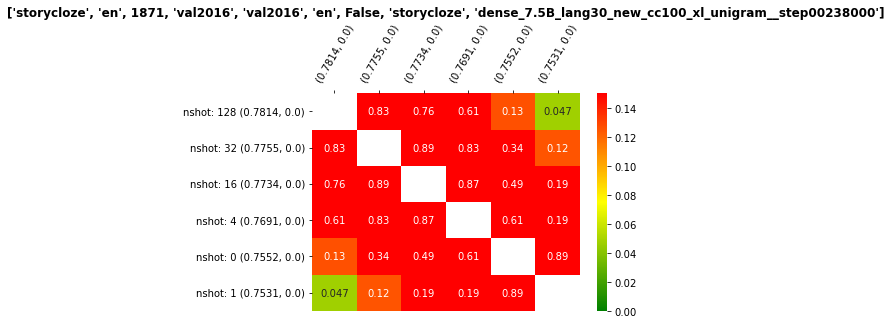

In [26]:
max_p_val=0.05
sig_matrix_mask = significance_matrix < 0
significance_matrix = np.around(significance_matrix, 3)
ax = sns.heatmap(significance_matrix, 
            mask=sig_matrix_mask, 
            xticklabels=model_labels_x_axis,
            yticklabels=model_labels_y_axis,
            vmin=0.00,
            vmax=3*max_p_val,
            annot=True,
            cmap=cmap_green_yellow_red)
plt.yticks(rotation=0)
ax.tick_params(axis='x', rotation=60)
ax.xaxis.tick_top() # x axis on top
ax.xaxis.set_label_position('top')
ax.set_title(predictions_with_index[0]["index_common"], weight='bold')

plt.show()

### Using pingouin.power_ttest to compare predictons_score (bootstrap also uses predictons_score)

In [53]:
import math

In [54]:
predictions_with_index = sorted(predictions_with_index, key=lambda x: x["mean_score"], reverse=True)

systems_count = len(predictions_with_index)
significance_matrix = -np.ones((systems_count, systems_count))

# print names with scores
model_scores = [(x["index_unique"], x["mean_score"]) for x in predictions_with_index]
model_labels_y_axis = [f"{x[0]} {(np.round(np.mean(x[1]),4), np.round(np.std(x[1]),4))}" for x in model_scores]
model_labels_x_axis = [f" {(np.round(np.mean(x[1]),4), np.round(np.std(x[1]),4))}" for x in model_scores]
        
for i0, systemA in enumerate(predictions_with_index):
    systemA_scores = systemA["predictons_score"]
    systemA_name = systemA["index_unique"]

    for i1, systemB in enumerate(predictions_with_index):
        systemB_scores = systemB["predictons_score"]
        systemB_name = systemB["index_unique"]
        if systemA_name == systemB_name:
            continue
        
#         statistic, pval = stats.ttest_ind(systemA_scores, systemB_scores)
        effect_size = np.mean(np.array(systemA_scores) - np.array(systemB_scores)) / \
                np.std(np.array(systemA_scores) - np.array(systemB_scores))
#         pval = ttpower.solve_power(effect_size=effect_size, nobs=len(systemA_scores), power=0.9, alternative='two-sided')
        pval = power_ttest(d=effect_size, n=len(systemA_scores)-1, power=0.9, alpha=None, alternative='two-sided')
        pval = 0 if math.isnan(pval) else pval
        significance_matrix[i0, i1] = pval
        significance_matrix[i1, i0] = pval

sig_matrix_mask = significance_matrix < 0
significance_matrix = np.around(significance_matrix, 3)

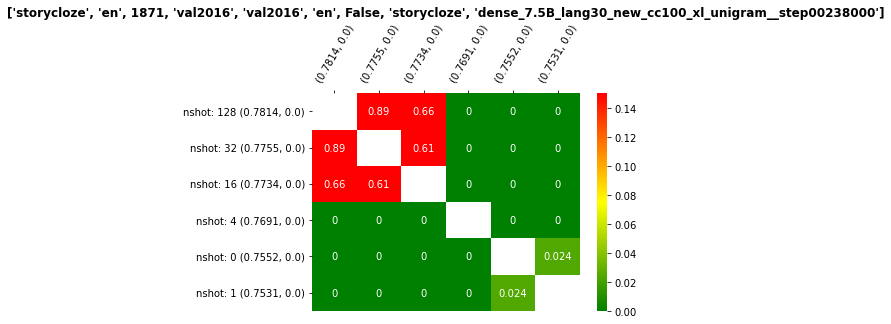

In [55]:
max_p_val=0.05
sig_matrix_mask = significance_matrix < 0
significance_matrix = np.around(significance_matrix, 3)
ax = sns.heatmap(significance_matrix, 
            mask=sig_matrix_mask, 
            xticklabels=model_labels_x_axis,
            yticklabels=model_labels_y_axis,
            vmin=0.00,
            vmax=3*max_p_val,
            annot=True,
            cmap=cmap_green_yellow_red)
plt.yticks(rotation=0)
ax.tick_params(axis='x', rotation=60)
ax.xaxis.tick_top() # x axis on top
ax.xaxis.set_label_position('top')
ax.set_title(predictions_with_index[0]["index_common"], weight='bold')

plt.show()

### Debug

In [13]:
eval_df = DataFrame.from_dict({item["index_unique"]: item["predictons_score"] for item in predictions_with_index})
eval_df.head()

,nshot: 128,nshot: 32,nshot: 16,nshot: 4,nshot: 0,nshot: 1
0,0.280650,0.263593,0.280584,0.260016,0.196577,0.206607
1,0.483209,0.479332,0.498131,0.493934,0.472274,0.482492
2,0.438454,0.456204,0.446501,0.433018,0.517107,0.478206
3,0.850550,0.806753,0.811968,0.812526,0.811896,0.833715
4,0.872183,0.874559,0.879948,0.886331,0.859098,0.866415


In [63]:
effect_size = np.mean(eval_df["nshot: 1"] - eval_df["nshot: 0"])\
    / np.std(eval_df["nshot: 1"] - eval_df["nshot: 0"])
power = 0.9
nobs = eval_df.shape[0] - 1
print(effect_size, nobs, power)

0.1158198413603465 1870 0.9


In [64]:
print(
    power_ttest(d=effect_size, n=nobs, power=power, alpha=None),
    power_ttest(d=0.2, n=1870, power=0.8, alpha=None),
    power_ttest(d=0.6560042558185867, n=None, power=0.8, alpha=0.05),
)

0.02389880253255857 1.4202810529907848e-07 37.46236508390684


In [65]:
import math
x = power_ttest(d=effect_size, n=nobs, power=power, alpha=None)
if not math.isnan(x):
    print(x)

0.02389880253255857


In [66]:
from statsmodels.stats.power import TTestPower

ttpower = TTestPower()

In [67]:
p1 = ttpower.solve_power(effect_size=effect_size, nobs=nobs, alpha=None, power=power, alternative='two-sided')
p2 = ttpower.solve_power(effect_size=effect_size, nobs=nobs, alpha=None, power=power, alternative='larger')
p3 = ttpower.solve_power(effect_size=effect_size, nobs=nobs, alpha=None, power=power, alternative='smaller')

print(effect_size, nobs, p1, p2, p3)

0.1158198413603465 1870 0.0002017462820680816 0.00010086895765799975 0.999999999999


In [58]:
! echo "library(pwr)" > /tmp/check.R
script = f"pwr.2p.test\(h={effect_size},n={nobs},power={0.9},sig.level=NULL\)"
! echo {script} >> /tmp/check.R
script = f"pwr.2p.test\(h={effect_size},n={nobs},power={0.8},sig.level=NULL\)"
! echo {script} >> /tmp/check.R
! cd /tmp && R CMD BATCH /tmp/check.R && cat /tmp/check.Rout


R version 3.6.1 (2019-07-05) -- "Action of the Toes"
Copyright (C) 2019 The R Foundation for Statistical Computing
Platform: x86_64-conda_cos6-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

> library(pwr)
> pwr.2p.test(h=0.11581984136034654,n=1870,power=0.9,sig.level=NULL)

     Difference of proportion power calculation for binomial distribution (arcsine transformation) 

              h = 0.1158198
              n = 1870
      sig.level = 0.02380226
          power = 0.9
    alternative = two.sided

NOTE: same sample sizes

> pwr.2p.test(h=0

# System comparison with Pairformance

TLDR: The paper "Better than Average: Paired Evaluation of NLP Systems" suggest using 
pairwise comparison between systems instead of average metrics like accuracy!

The paper uses the method to rank systems that produce continuos scores like BLEU. 
In our evaluation below, we use the probability assigned to the correct answer for our multi-choice tasks.

Please, look at https://github.com/epfl-dlab/pairformance before going further down this notebook!

In [20]:
#eval_df = pd.read_csv('dialogue_example_df.csv')
eval_df = DataFrame.from_dict({item["index_unique"]: item["predictons_score"] for item in predictions_with_index})
eval_df.head()


,nshot: 128,nshot: 32,nshot: 16,nshot: 4,nshot: 0,nshot: 1
0,0.280650,0.263593,0.280584,0.260016,0.196577,0.206607
1,0.483209,0.479332,0.498131,0.493934,0.472274,0.482492
2,0.438454,0.456204,0.446501,0.433018,0.517107,0.478206
3,0.850550,0.806753,0.811968,0.812526,0.811896,0.833715
4,0.872183,0.874559,0.879948,0.886331,0.859098,0.866415


In [21]:
print(f" Systems: {eval_df.columns.to_list()},\n number of test instances: {eval_df.shape[0]}")

 Systems: ['nshot: 128', 'nshot: 32', 'nshot: 16', 'nshot: 4', 'nshot: 0', 'nshot: 1'],
 number of test instances: 1871


## Start Pairformance

In [22]:
print("Default config:")
pp.pprint(DEFAULT_CONFIG)

Default config:
{   'aggregations': ['Mean', 'Median', 'BT'],
    'compute_pairwise': True,
    'epsilon_bt': 1e-09,
    'n_bootstrap': 100,
    'pval_threshold': 0.05}


- `aggregations`: a list of aggregation mechanisms to consider
- `compute_pairwise`: whether to run the analyses for each pair of systems
- `epsilon_bt`: when the iterative algorithm of BT does not vary by more than epsilon_bt, we stop.
- `n_bootstrap`: number of bootstrap resample of the data to take to compute confidence intervals
- `pval_threshold`: percentile to use for confidence interval. Example: 0.05 gives the (5, 95) percentiles.

In [23]:
pf_config = DEFAULT_CONFIG.copy()
pf_config["aggregations"] = ['Mean', 'Median', "BT"]
pf_config['n_bootstrap'] = 100

pf_eval = pairformance.Pairformance(df=eval_df, config=pf_config)

## Default Usage

In [46]:
results = pf_eval.eval()
global_results = pf_eval.print_global_results()
pairwise_results = pf_eval.print_pairwise_results()



===== Global Results =====

*** Mean ***
	     Systems       Est. score    (95% bootstrap CI)
	   nshot: 128         0.658      (0.649, 0.665) 
	    nshot: 32         0.658      (0.649, 0.664) 
	    nshot: 16         0.657      (0.647, 0.663) 
	    nshot: 4          0.650      (0.641, 0.656) 
	    nshot: 0          0.634      (0.624, 0.640) 
	    nshot: 1          0.637      (0.628, 0.644) 

*** Median ***
	     Systems       Est. score    (95% bootstrap CI)
	   nshot: 128         0.683      (0.674, 0.693) 
	    nshot: 32         0.683      (0.671, 0.694) 
	    nshot: 16         0.682      (0.672, 0.692) 
	    nshot: 4          0.675      (0.665, 0.684) 
	    nshot: 0          0.653      (0.643, 0.664) 
	    nshot: 1          0.657      (0.647, 0.667) 

*** BT ***
	     Systems       Est. score    (95% bootstrap CI)
	   nshot: 128         0.214      (0.204, 0.224) 
	    nshot: 32         0.207      (0.202, 0.214) 
	    nshot: 16         0.220      (0.213, 0.227) 
	    nshot: 4       

### Description of the returned variables

**Outputs from pf_eval.eval()**:
- `results['global-results']`: contains the global estimates for each aggregation mechanism defined in the config
- `results['global-results'][Agg]`: is a pd.DataFrame with n_bootstrap row, one row for one resampled estimate
- `results['pairwise-results']`: contains the pairwise comparison for each pair of systems

**Outputs from self.print_global_results()**: the same information as `results['global-results']` but with the confidence intervals computed from the resampled estimates.

**Outputs from self.print_pairwise_results()**: the same information as `results['pairwise-results']` but with the confidence intervals computed from the resampled estimates

## Probability that one system is better than other

In [47]:
example_system_A = 'nshot: 128'
example_system_B = 'nshot: 32'
p_m0_m1, pval_m0_m1 = pf_eval.prob_a_better_b(example_system_A, example_system_B)
print(f"Prob that {example_system_A} is better than {example_system_B} {p_m0_m1}, pval {pval_m0_m1}")

Prob that nshot: 128 is better than nshot: 32 0.49545697487974344, pval 0.7114683958004907


## Visualization of results

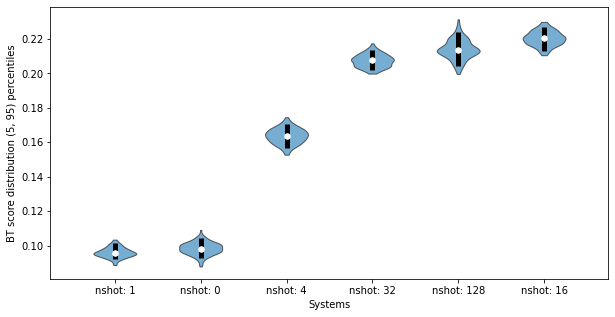

In [48]:
## Plot the distribution of BT estimates coming from bootstrap resamples
plotting_utils.plot_global_results(pf_eval, aggregation='BT')

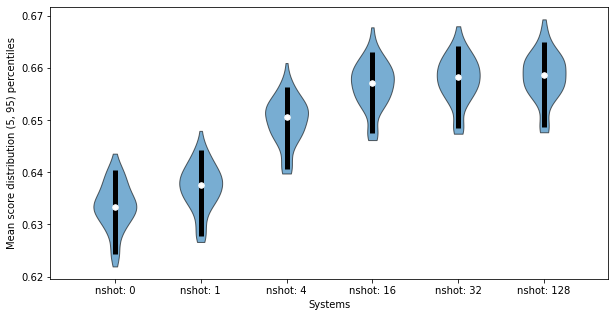

In [49]:
## Plot the distribution of mean estimates coming from bootstrap resamples
plotting_utils.plot_global_results(pf_eval, aggregation='Mean')

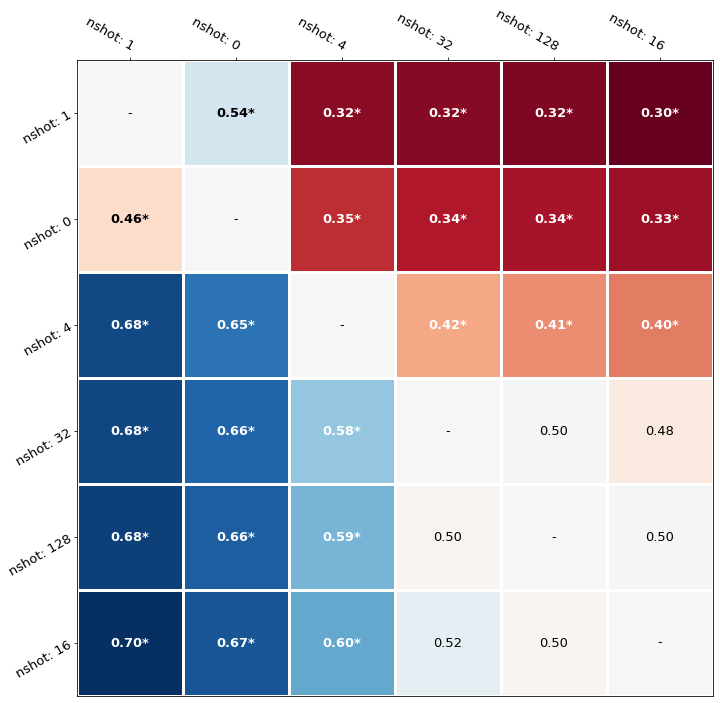

In [50]:
## Plot pairwise structure for BT (BT pairwise is different than BT global)
plotting_utils.plot_matrix_results(pf_eval, aggregation='BT', fontsize=13, save_path=None)

In this matrix, the element at row i and column j is the probability that the system of row i is better than the system of column j

The star marks statistically significant difference according to the sign test (for BT)

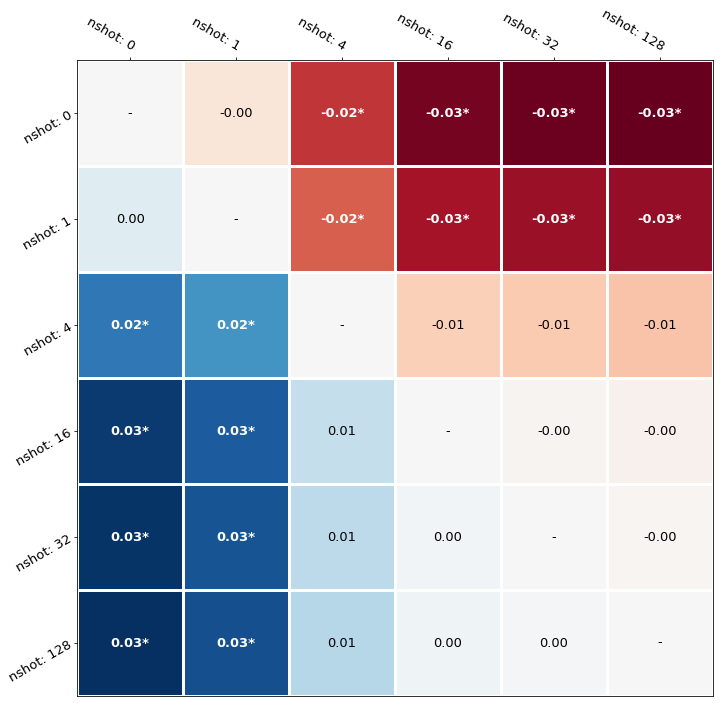

In [51]:
plotting_utils.plot_matrix_results(pf_eval, aggregation='Median', fontsize=13, save_path=None)

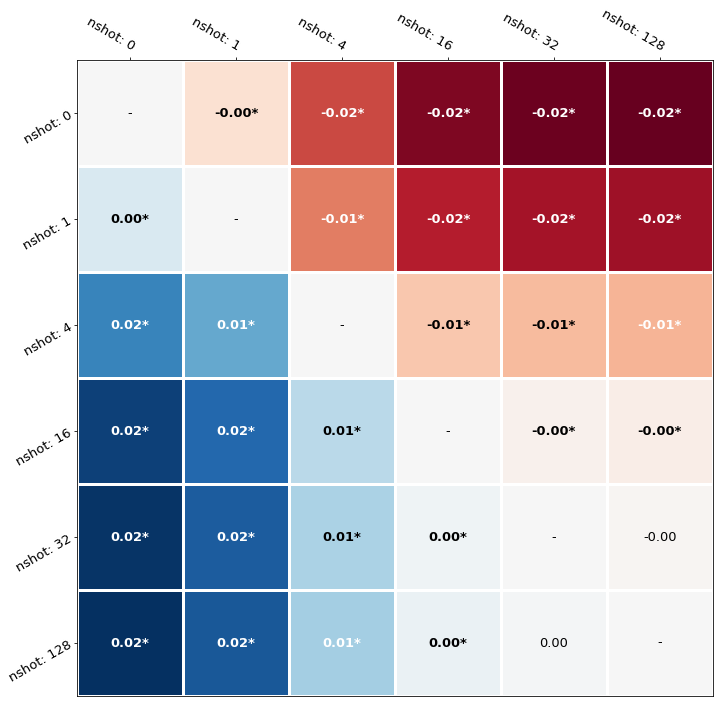

In [52]:
plotting_utils.plot_matrix_results(pf_eval, aggregation='Mean', fontsize=13, save_path=None)

In this matrix, the element at row i and column j is the difference between the median of system of row i and the system of column j
The star marks statistically significant difference according to the Mood\'s median test (for Median)

## Diagnostic capabilities

### Computing statistics of the system scores

- `global-outliers-percentage`: take the whole array of data and compute the percentage of outliers
- `per-system-outliers-percentage`: percentage of outliers for each system independently
- `mean-row-std`: measure the std per test instance, then average this std across test instances, i.e., how much variance is there across system 
- `rank-std-across-rows`: computes the order of systems per test instance, and measure how much the ranking varies across test instances, i.e., how much variance is there across ranking of systems
- `std-of-row-means`: computes the mean score of each test instance (across systems) and measure the std across test instances, i.e., how much overall scores vary across test instances

In [53]:
pp.pprint(pf_eval.diagnostic_system_scores(eval_df))

{   'global-outliers-percentage': 0.004988419739889542,
    'mean-row-std': 0.0273484765168764,
    'per-system-outliers-percentage': {   'nshot: 0': 0.004810261892036344,
                                          'nshot: 1': 0.004810261892036344,
                                          'nshot: 128': 0.005344735435595938,
                                          'nshot: 16': 0.004810261892036344,
                                          'nshot: 32': 0.004810261892036344,
                                          'nshot: 4': 0.005344735435595938},
    'rank-std-across-rows': {   'nshot: 0': 2.015255484919502,
                                'nshot: 1': 1.532393302923694,
                                'nshot: 128': 1.7759431609434553,
                                'nshot: 16': 1.4521937991684288,
                                'nshot: 32': 1.5575768759969357,
                                'nshot: 4': 1.3672424074668328},
    'std-of-row-means': 0.19558591606511067}


### Computing disagreements between the aggregation mechanisms for this data

In this case, we observe that there is good agreement between mean, median, and BT

In [54]:
_ = pf_eval.diagnostic_aggregation_agreement()



===== Aggregation Agreement =====
	       Pairs of Agg.       Percentage Aggr.    Same Sota      Same Top-3   
	      Mean vs. Median           1.00            True            True      
	        Mean vs. BT             0.80            False           False     
	       Median vs. BT            0.80            False           False     


### plotting paired graph

It show the paired structure of a pair of system. 
Each dot is one test instances whose coordinates are given by the score it receives according to the two systems.
This is shown as a density plot, if more density is above the dotted line the y-axis system is better according to BT.
Otherwise, the x-axis system is better according to BT.
See paper for more details!

In this case, the medians intersects below the dotted line, i.e., Median makes M1 better
More mass is on the space above the dotted line, i.e., BT makes M2 better
The means intersect on the dotted line, i.e., Mean does not distinguish between M2 and M1

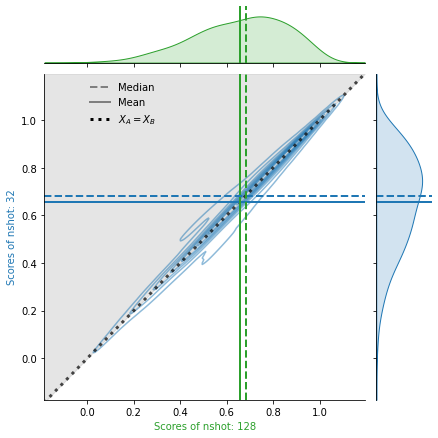

In [55]:
plotting_utils.plot_paired_graphs(eval_df, example_system_B, example_system_A)